# Finite-strain elastoplasticity within the logarithmic strain framework

This demo is dedicated to the resolution of a finite-strain elastoplastic problem using the logarithmic strain framework proposed in {cite:p}`miehe2002anisotropic`.

```{tip}
This simulation is a bit heavy to run so we suggest running it in parallel.
```

## Logarithmic strains

This framework expresses constitutive relations between the Hencky strain measure $\boldsymbol{H} = \dfrac{1}{2}\log (\boldsymbol{F}^\text{T}\cdot\boldsymbol{F})$ and its dual stress measure $\boldsymbol{T}$. This approach makes it possible to extend classical small strain constitutive relations to a finite-strain setting. In particular, the total (Hencky) strain can be split additively into many contributions (elastic, plastic, thermal, swelling, etc.) e.g. $\boldsymbol{H}=\boldsymbol{H}^e+\boldsymbol{H}^p$. Its trace is also linked with the volume change $J=\exp(\operatorname{tr}(\boldsymbol{H}))$. As a result, the deformation gradient $\boldsymbol{F}$ is used for expressing the Hencky strain $\boldsymbol{H}$, a small-strain constitutive law is then written for the $(\boldsymbol{H},\boldsymbol{T})$-pair and the dual stress $\boldsymbol{T}$ is then post-processed to an appropriate stress measure such as the Cauchy stress $\boldsymbol{\sigma}$ or Piola-Kirchhoff stresses.

## `MFront` implementation

The logarithmic strain framework discussed in the previous paragraph consists merely as a pre-processing and a post-processing stages of the behavior integration. The pre-processing stage compute the logarithmic strain and its increment and the post-processing stage inteprets the stress resulting from the behavior integration as the dual stress $\boldsymbol{T}$ and convert it to the Cauchy stress.

`MFront` provides the `@StrainMeasure` keyword that allows to specify which strain measure is used by the behavior. When choosing the `Hencky` strain measure, `MFront` automatically generates those pre- and post-processing stages, allowing the user to focus on the behavior integration.

This leads to the following implementation (see the [small-strain elastoplasticity example](https://thelfer.github.io/mgis/web/mgis_fenics_small_strain_elastoplasticity.html) for details about the various implementations available):

```
@DSL Implicit;

@Behaviour LogarithmicStrainPlasticity;
@Author Thomas Helfer/Jérémy Bleyer;
@Date 07 / 04 / 2020;

@StrainMeasure Hencky;

@Algorithm NewtonRaphson;
@Epsilon 1.e-14;
@Theta 1;

@MaterialProperty stress s0;
s0.setGlossaryName("YieldStress");
@MaterialProperty stress H0;
H0.setEntryName("HardeningSlope");

@Brick StandardElastoViscoPlasticity{
  stress_potential : "Hooke" {
	    young_modulus : 210e9,
        poisson_ratio : 0.3
        },
  inelastic_flow : "Plastic" {
    criterion : "Mises",
    isotropic_hardening : "Linear" {H : "H0", R0 : "s0"}
  }
};
```

## `FEniCSx` implementation

We define a box mesh representing half of a beam oriented along the $x$-direction. The beam will be fully clamped on its left side and symmetry conditions will be imposed on its right extremity. The loading consists of a uniform self-weight.

```{image} finite_strain_plasticity_solution.png
:align: center
:width: 500px
```

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import ufl
from petsc4py import PETSc
from mpi4py import MPI
from dolfinx import fem, mesh, io
from dolfinx_materials.quadrature_map import QuadratureMap
from dolfinx_materials.mfront import MFrontMaterial
from dolfinx_materials.solvers import NonlinearMaterialProblem
from dolfinx_materials.utils import (
    nonsymmetric_tensor_to_vector,
)


comm = MPI.COMM_WORLD
rank = comm.rank

current_path = os.getcwd()

length, width, height = 1.0, 0.04, 0.1
nx, ny, nz = 20, 4, 6
domain = mesh.create_box(
    comm,
    [(0, -width / 2, -height / 2.0), (length, width / 2, height / 2.0)],
    [nx, ny, nz],
    cell_type=mesh.CellType.tetrahedron,
    ghost_mode=mesh.GhostMode.none,
)
gdim = domain.topology.dim


V = fem.functionspace(domain, ("P", 2, (gdim,)))


def left(x):
    return np.isclose(x[0], 0)


def right(x):
    return np.isclose(x[0], length)


left_dofs = fem.locate_dofs_geometrical(V, left)
V_x, _ = V.sub(0).collapse()
right_dofs = fem.locate_dofs_geometrical((V.sub(0), V_x), right)

uD = fem.Function(V_x)
bcs = [
    fem.dirichletbc(np.zeros((gdim,)), left_dofs, V),
    fem.dirichletbc(uD, right_dofs, V.sub(0)),
]

selfweight = fem.Constant(domain, np.zeros((gdim,)))

du = ufl.TrialFunction(V)
v = ufl.TestFunction(V)
u = fem.Function(V, name="Displacement")

The `MFrontMaterial` instance is loaded from the `MFront` `LogarithmicStrainPlasticity` behavior. This behavior is a finite-strain behavior (`material.is_finite_strain=True`) which relies on a kinematic description using the total deformation gradient $\boldsymbol{F}$. By default, a `MFront` behavior always returns the Cauchy stress as the stress measure after integration. However, the stress variable dual to the deformation gradient is the first Piola-Kirchhoff (PK1) stress. An internal option of the MGIS interface is therefore used in the finite-strain context to return the PK1 stress as the "flux" associated to the "gradient" $\boldsymbol{F}$. Both quantities are non-symmetric tensors, aranged as a 9-dimensional vector in 3D following [`MFront` conventions on tensors](https://thelfer.github.io/tfel/web/tensors.html).

In [2]:
material = MFrontMaterial(
    os.path.join(current_path, "src/libBehaviour.so"),
    "LogarithmicStrainPlasticity",
    material_properties={"YieldStrength": 250e6, "HardeningSlope": 1e6},
)
if rank == 0:
    print(material.behaviour.getBehaviourType())
    print(material.behaviour.getKinematic())
    print(material.gradient_names, material.gradient_sizes)
    print(material.flux_names, material.flux_sizes)

StandardFiniteStrainBehaviour
F_CAUCHY
['DeformationGradient'] [9]
['FirstPiolaKirchhoffStress'] [9]


In this large-strain setting, the `QuadratureMapping` acts from the deformation gradient $\boldsymbol{F}=\boldsymbol{I}+\nabla\boldsymbol{u}$ to the first Piola-Kirchhoff stress $\boldsymbol{P}$. We must therefore register the deformation gradient as `Identity(3)+grad(u)`.

In [3]:
def F(u):
    return nonsymmetric_tensor_to_vector(ufl.Identity(gdim) + ufl.grad(u))


def dF(u):
    return nonsymmetric_tensor_to_vector(ufl.grad(u))


qmap = QuadratureMap(domain, 2, material)
qmap.register_gradient("DeformationGradient", F(u))

We will work in a Total Lagrangian formulation, writing the weak form of equilibrium on the reference configuration $\Omega_0$, thereby defining the nonlinear residual weak form as:
Find $\boldsymbol{u}\in V$ such that:

$$
\int_{\Omega_0} \boldsymbol{P}(\boldsymbol{F}(\boldsymbol{u})):\nabla \boldsymbol{v} \,\text{d}\Omega - \int_{\Omega_0} \boldsymbol{f}\cdot\boldsymbol{v}\,\text{d}\Omega = 0 \quad \forall \boldsymbol{v}\in V
$$
where $\boldsymbol{f}$ is the self-weight.

The corresponding Jacobian form is computed via automatic differentiation. As for the [small-strain elastoplasticity example](https://thelfer.github.io/mgis/web/mgis_fenics_small_strain_elastoplasticity.html), state variables include the `ElasticStrain` and `EquivalentPlasticStrain` since the same behavior is used as in the small-strain case with the only difference that the total strain is now given by the Hencky strain measure. In particular, the `ElasticStrain` is still a symmetric tensor (vector of dimension 6). Note that it has not been explicitly defined as a state variable in the `MFront` behavior file since this is done automatically when using the `IsotropicPlasticMisesFlow` parser.

In [4]:
PK1 = qmap.fluxes["FirstPiolaKirchhoffStress"]
Res = (ufl.dot(PK1, dF(v)) - ufl.dot(selfweight, v)) * qmap.dx
Jac = qmap.derivative(Res, u, du)

Finally, we setup the nonlinear problem, the corresponding Newton solver and solve the load-stepping problem.

In [5]:

petsc_options = {
    "snes_type": "newtonls",
    "snes_linesearch_type": "none",
    "snes_atol": 1e-8,
    "snes_rtol": 1e-8,
    "ksp_type": "preonly",
    "pc_type": "lu",
    "pc_factor_mat_solver_type": "mumps",
}
problem = NonlinearMaterialProblem(
    qmap,
    Res,
    u,
    bcs=bcs,
    J=Jac,
    petsc_options_prefix="elastoplasticity",
    petsc_options=petsc_options,
)

Nincr = 30
load_steps = np.linspace(0.0, 1.0, Nincr + 1)

vtk = io.VTKFile(domain.comm, f"results/{material.name}.pvd", "w")
results = np.zeros((Nincr + 1, 2))
for i, t in enumerate(load_steps[1:]):
    selfweight.value[-1] = -50e6 * t

    problem.solve()
    converged = problem.solver.getConvergedReason()
    num_iter = problem.solver.getIterationNumber()

    if rank == 0:
        print(f"Increment {i+1} converged in {num_iter} iterations.")

    p0 = qmap.project_on("EquivalentPlasticStrain", ("DG", 0))

    vtk.write_function(u, t)
    vtk.write_function(p0, t)

    w = u.sub(2).collapse()
    local_max = max(np.abs(w.x.array))
    # Perform the reduction to get the global maximum on rank 0
    global_max = comm.reduce(local_max, op=MPI.MAX, root=0)
    results[i + 1, 0] = global_max
    results[i + 1, 1] = t
vtk.close()

Increment 1 converged in 3 iterations.
Increment 2 converged in 3 iterations.
Increment 3 converged in 3 iterations.
Increment 4 converged in 3 iterations.
Increment 5 converged in 3 iterations.
Increment 6 converged in 3 iterations.
Increment 7 converged in 3 iterations.
Increment 8 converged in 3 iterations.
Increment 9 converged in 4 iterations.
Increment 10 converged in 4 iterations.
Increment 11 converged in 5 iterations.
Increment 12 converged in 5 iterations.
Increment 13 converged in 6 iterations.
Increment 14 converged in 6 iterations.
Increment 15 converged in 6 iterations.
Increment 16 converged in 6 iterations.
Increment 17 converged in 7 iterations.
Increment 18 converged in 8 iterations.
Increment 19 converged in 7 iterations.
Increment 20 converged in 6 iterations.
Increment 21 converged in 6 iterations.
Increment 22 converged in 6 iterations.
Increment 23 converged in 6 iterations.
Increment 24 converged in 6 iterations.
Increment 25 converged in 6 iterations.
Increment

During the load incrementation, we monitor the evolution of the maximum vertical downwards displacement.
The load-displacement curve exhibits a classical elastoplastic behavior rapidly followed by a stiffening behavior due to membrane catenary effects.

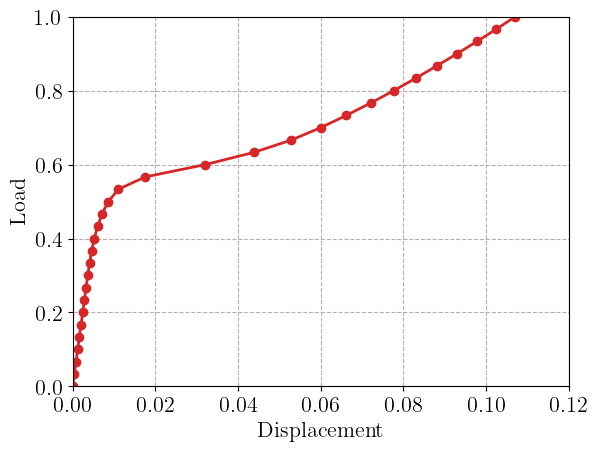

In [6]:
if rank == 0:
    plt.figure()
    plt.plot(results[:, 0], results[:, 1], "-oC3")
    plt.xlabel("Displacement")
    plt.ylabel("Load")
    plt.show()

Finally, we report the total time spent in the nonlinear solver against the time spent inside the constitutive update function.

In [8]:
from dolfinx.common import timing

snes_solve = timing("SNES: solve")[1].total_seconds()
print(f"Total solving time {snes_solve:.2f}s")
constitutive_update_time = timing("SNES: constitutive update")[1].total_seconds()
print(f"Total time spent in constitutive update {constitutive_update_time:.2f}s")

Total solving time 36.16s
Total time spent in constitutive update 6.97s


## References

```{bibliography}
:filter: docname in docnames
```